<a href="https://colab.research.google.com/github/sophie55555/AIFFEL_quest_crAIFFEL_quest_cr/blob/main/20250312_image_segmentation(sam%2Cdog%2Cmask).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import requests
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image, ImageFilter
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


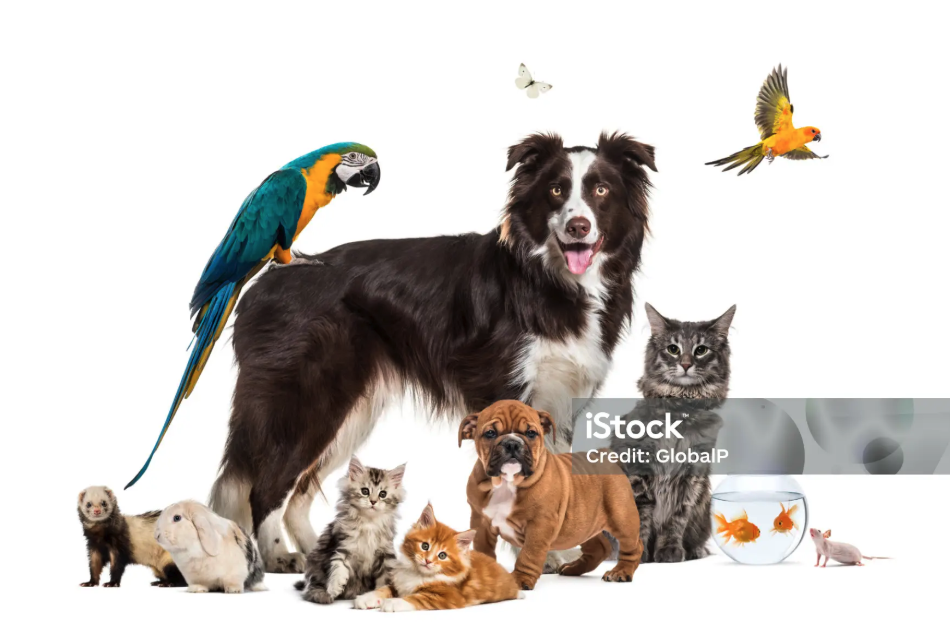

In [48]:
location = "/content/drive/MyDrive/data/15.png"
image = Image.open(location).convert("RGB")
image

In [49]:
image.size

(950, 626)

In [50]:
offset = round(image.size[0] / 2) - round(image.size[1] / 2)
offset += 20
offset

182

In [51]:
cropped_img = image.crop((offset, 0, image.size[1] + offset, image.size[1]))

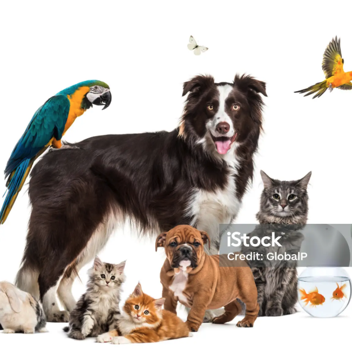

In [52]:
resized_img = cropped_img.resize((352, 352))

resized_img

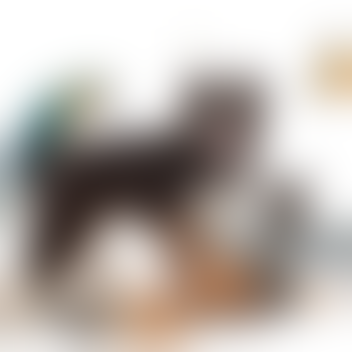

In [53]:
img_array = np.array(resized_img)
img_uint8 = (img_array).astype(np.uint8)
num_iterations = 1
blur_radius = 20
blurred_image = Image.fromarray(img_uint8)
for _ in range(num_iterations):
  blurred_image = blurred_image.filter(ImageFilter.GaussianBlur(radius=blur_radius))

blurred_image

In [54]:
processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

a clear photo of a dog - 프롬프트 dog에서 변경

In [55]:
prompts = ["a clear photo of a dog"]

In [56]:
inputs = processor(text=prompts, images=[resized_img] * len(prompts), padding="max_length", return_tensors="pt")

# predict
with torch.no_grad():
  outputs = model(**inputs, interpolate_pos_encoding=True)

preds = outputs.logits.unsqueeze(1)

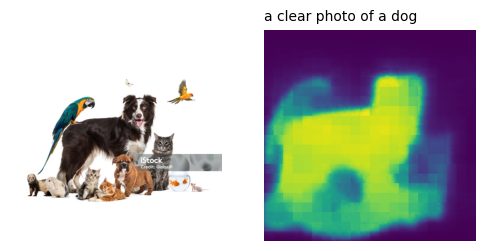

In [57]:
_, ax = plt.subplots(1, len(prompts) + 1, figsize=(3*(len(prompts) + 1), 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(image)
[ax[i+1].imshow(torch.sigmoid(preds[i][0])) for i in range(len(prompts))];
[ax[i+1].text(0, -15, prompt) for i, prompt in enumerate(prompts)];

shallow focus effect

In [58]:
def make_shallow_focus(segmentation_image, original_image):
    segmentation_map = segmentation_image.cpu().numpy()

    # Normalize segmentation map to range 0-1
    segmentation_map = (segmentation_map - segmentation_map.min()) / (segmentation_map.max() - segmentation_map.min())

    # Convert the segmentation map to uint8 for processing
    segmentation_map = (segmentation_map * 255).astype(np.uint8)

    # Create a PIL image from the segmentation map
    segmentation_image = Image.fromarray(segmentation_map)
    # segmentation_image = segmentation_image.filter(ImageFilter.DETAIL)
    # segmentation_image = segmentation_image.filter(ImageFilter.EDGE_ENHANCE)

    # Image to numpy array
    img_array = np.array(original_image)
    img_uint8 = (img_array).astype(np.uint8)

    # Create a blurred version of the original image
    num_iterations = 1
    # blur_radius = 20
    blurred_image = Image.fromarray(img_uint8)
    for _ in range(num_iterations):
      # blurred_image = blurred_image.filter(ImageFilter.GaussianBlur(radius=blur_radius))
      blurred_image = Image.fromarray(img_uint8).filter(ImageFilter.BLUR)

    # Create a shallow-focused image using the segmentation map
    shallow_focus = Image.composite(Image.fromarray(img_uint8), blurred_image, segmentation_image)

    return shallow_focus

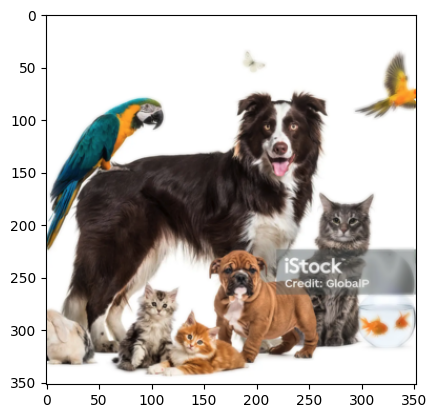

In [60]:
shallow_focus = make_shallow_focus(preds[0][0], resized_img)
plt.imshow(shallow_focus)

In [61]:
# save the final shallow-focused image
shallow_focus.save("my_image_shallow-focused.jpg")  # Save the image

SAM

Meta’s SAM: Easy Image Segmentation with Minimal Code. | by Youssef ALBAGOURY | GoPenAI

In [62]:
from transformers import pipeline

generator = pipeline("mask-generation", model="facebook/sam-vit-large", device=0)

Device set to use cuda:0


In [63]:
import numpy as np
import matplotlib.pyplot as plt
import gc

def show_mask(mask, ax, random_color=False, mask_id=None):  # Add mask_id
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

    if mask_id is not None:  # Display mask number
        # Calculate centroid for text position
        y, x = np.where(mask.squeeze()) # Find indices of True values
        if len(x) > 0 and len(y) > 0: # Check if any True values are found
            centroid_x = int(np.mean(x))
            centroid_y = int(np.mean(y))

            ax.text(centroid_x, centroid_y, str(mask_id), color="white", fontsize=7, ha="center", va="center")

    del mask
    gc.collect()

def show_masks_on_image(raw_image, masks, filename="masked_image.png"):
    fig, ax = plt.subplots()  # Create the figure and axes explicitly.  This is important so we can save it correctly later.
    ax.imshow(np.array(raw_image)) # Use the ax object
    ax.set_autoscale_on(False)

    for i, mask in enumerate(masks):
        show_mask(mask, ax=ax, random_color=True, mask_id=i)

    ax.axis("off")  # Use the ax object

    fig.savefig(filename, bbox_inches='tight', pad_inches=0)  # Save the figure
    plt.close(fig)  # Close the figure to free memory.  Pass the fig object to close()
    del mask
    gc.collect()
    return ax # Return the axes object

In [64]:
image = Image.open("/content/drive/MyDrive/data/15.png").convert("RGB")

points_per_batch (SAM 관련):

의미: points_per_batch는 SAM (Segment Anything Model)에서 한 번에 처리하는 포인트의 수를 나타냅니다. SAM은 포인트 기반 세그멘테이션 모델이므로, 이미지에서 분할할 영역을 지정하기 위해 사용자가 포인트를 제공해야 합니다. points_per_batch는 이러한 포인트를 배치 단위로 묶어서 모델에 전달할 때, 각 배치에 포함되는 포인트의 개수를 의미합니다.

영향:

값이 클수록: 한 번에 더 많은 포인트를 처리하므로, 세그멘테이션 속도가 빨라질 수 있습니다. 하지만 GPU 메모리 사용량이 증가할 수 있으며, 너무 큰 값을 사용하면 메모리 부족 오류가 발생할 수 있습니다.

값이 작을수록: GPU 메모리 사용량을 줄일 수 있지만, 세그멘테이션 속도가 느려질 수 있습니다.

In [65]:
outputs = generator(image, points_per_batch=64)

In [67]:
masks = outputs["masks"]
ax_returned = show_masks_on_image(image, masks, filename="my_masked_image.png")

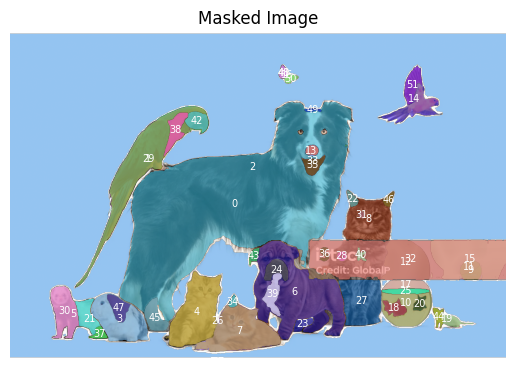

In [68]:
ax_returned.set_title("Masked Image")
plt.figure(ax_returned.figure) # Important: Get the figure that contains the axes
plt.show() # Now show the plot

In [69]:
def show_masks_on_image(raw_image, masks, filename=None):
    fig, ax = plt.subplots(figsize=(14, 8))  # Create the figure and axes explicitly.  This is important so we can save it correctly later.
    ax.imshow(np.array(raw_image)) # Use the ax object
    # ax.set_autoscale_on(False)

    for i, mask in enumerate(masks):
        show_mask(mask, ax=ax, random_color=True, mask_id=i)

    ax.axis("off")  # Use the ax object
    if filename is not None:
      fig.savefig(filename, bbox_inches='tight', pad_inches=0)
    plt.close(fig)  # Close the figure to free memory.  Pass the fig object to close()
    del mask
    gc.collect()
    return ax # Return the axes object

In [70]:
def rgb_complementary(rgb_color):
    """Gets the approximate complementary color for an RGB tuple.

    Args:
        rgb_color: A tuple of (red, green, blue) values (0-255).

    Returns:
        A tuple of (red, green, blue) representing the complementary color.
    """
    r, g, b, a = rgb_color
    return (1 - r, 1 - g, 1 - b, a)

마스크 개선 함수 추가

In [71]:
# 7. 마스크 개선 함수 (침식 및 팽창)
def refine_mask(mask, erosion_kernel_size, dilation_kernel_size):
    """
    침식 및 팽창 연산을 사용하여 마스크의 노이즈를 줄이고 경계를 부드럽게 만듭니다.
    """
    erosion_kernel = np.ones((erosion_kernel_size, erosion_kernel_size), np.uint8)
    erosion = cv2.erode(mask.astype(np.uint8), erosion_kernel, iterations=1)  # 마스크를 uint8로 변환

    dilation_kernel = np.ones((dilation_kernel_size, dilation_kernel_size), np.uint8)
    dilation = cv2.dilate(erosion, dilation_kernel, iterations=1)

    return dilation.astype(bool)  # 다시 bool 타입으로 변환

In [72]:
import random

def show_mask(mask, ax, random_color=False, mask_id=None):  # Add mask_id
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

    # color_rgb = (color * 255).astype(int)
    color_crgb = rgb_complementary(color)

    if mask_id is not None:  # Display mask number
        # Calculate centroid for text position
        y, x = np.where(mask.squeeze()) # Find indices of True values
        if len(x) > 0 and len(y) > 0: # Check if any True values are found
            min_x = int(np.min(x))
            min_y = int(np.min(y))
            max_x = int(np.max(x))
            max_y = int(np.max(y))

            centroid_x = int(np.mean(x))
            centroid_y = int(np.mean(y))

            # max_x = max_x - 10  # Maximum x-coordinate (0-indexed)
            # max_y = max_y - 10  # Maximum y-coordinate

            # Generate random x and y with a step of 10
            x = random.randrange(centroid_x - 30, centroid_x + 30, 10)  # Generates values from 0 up to and including max_x
            y = random.randrange(centroid_y - 30, centroid_y + 30, 10)

            ax.text(x, y, str(mask_id), color=color_crgb, fontsize=7, ha="center", va="center")
            linewidth = 0.5
            ax.plot([min_x, x - 10], [min_y, y - 10], color=color_crgb, linewidth=linewidth)
            ax.plot([max_x, x + 10], [max_y, y + 10], color=color_crgb, linewidth=linewidth)
            ax.plot([min_x, x - 10], [max_y, y + 10], color=color_crgb, linewidth=linewidth)
            ax.plot([max_x, x + 10], [min_y, y - 10], color=color_crgb, linewidth=linewidth)

In [73]:
color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
# color_rgb = (color * 255).astype(int)
color_crgb = rgb_complementary(color)
color_crgb

(0.3314310323759416, 0.1206435408325629, 0.6752012003726913, 0.6)

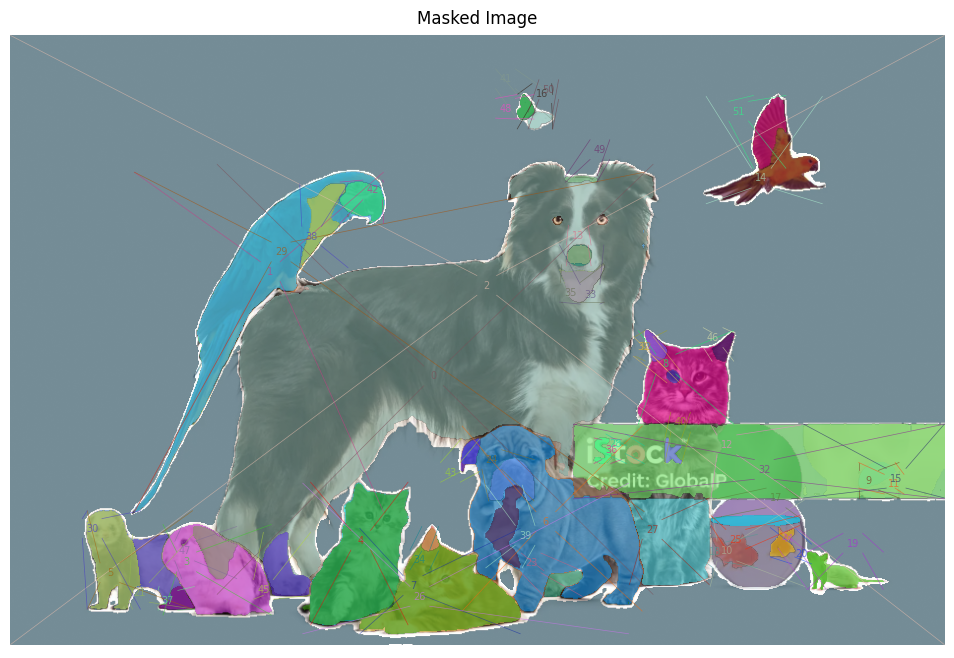

In [74]:
masks = outputs["masks"]
ax_returned = show_masks_on_image(image, masks, filename="my_masked_image.png")
ax_returned.set_title("Masked Image")
plt.figure(ax_returned.figure) # Important: Get the figure that contains the axes
plt.show() # Now show the plot

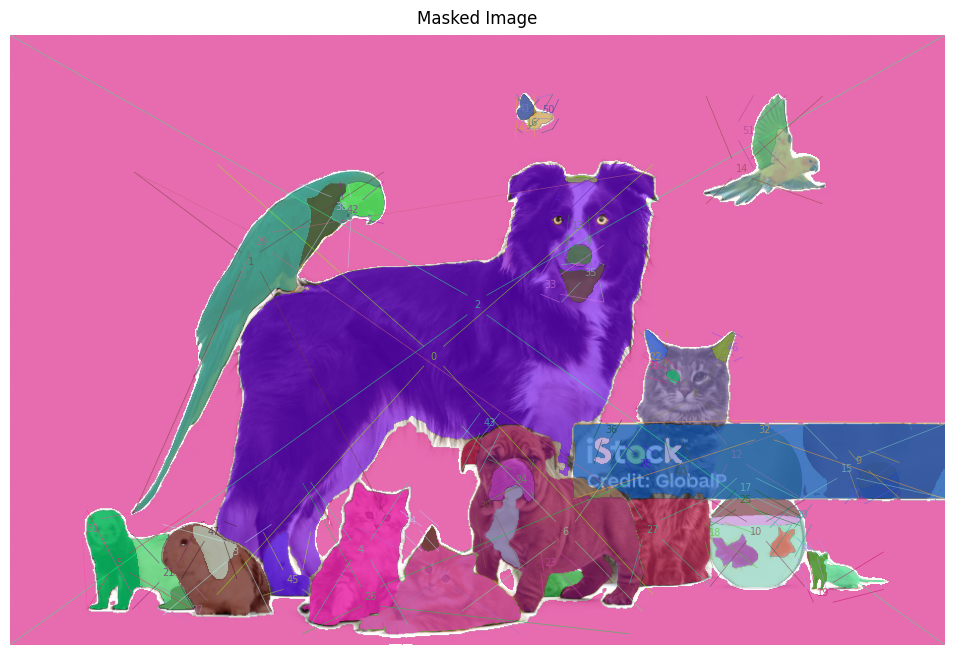

In [75]:
masks = outputs["masks"]
ax_returned = show_masks_on_image(image, masks, filename="my_masked_image")
ax_returned.set_title("Masked Image")
plt.figure(ax_returned.figure) # Important: Get the figure that contains the axes
plt.show() # Now show the plot

mask on image

In [76]:
def mask_on_img(image, mask):
  plt.imshow(image)
  ax = plt.gca()
  ax.set_autoscale_on(False)
  show_mask(mask, ax=ax, random_color=True)
  plt.axis("off")
  plt.show()

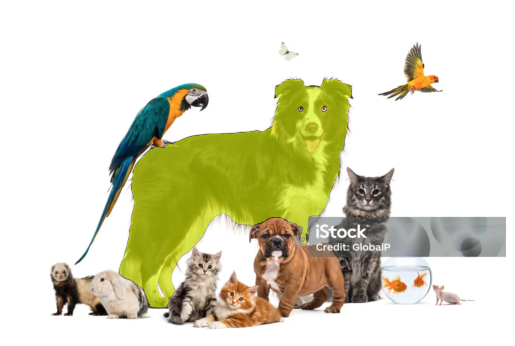

In [77]:
mask_on_img(image, masks[0])

In [78]:
from PIL import Image, ImageFilter

def create_shallow_focus(image, mask, blur_radius=5):
    """Creates a shallow focus image using the masks."""

    image_pil = Image.fromarray(np.array(image))  # Convert to PIL Image

    # Create blurred image
    blurred_image = image_pil.filter(ImageFilter.GaussianBlur(radius=blur_radius))

    # Composite the images using the masks
    shallow_focus_image = image_pil.copy() # Copy the image to avoid modifying the original

    mask_pil = Image.fromarray((mask * 255).astype(np.uint8))
    shallow_focus_image = Image.composite(shallow_focus_image, blurred_image, mask_pil) # Composite using the mask

    return shallow_focus_image

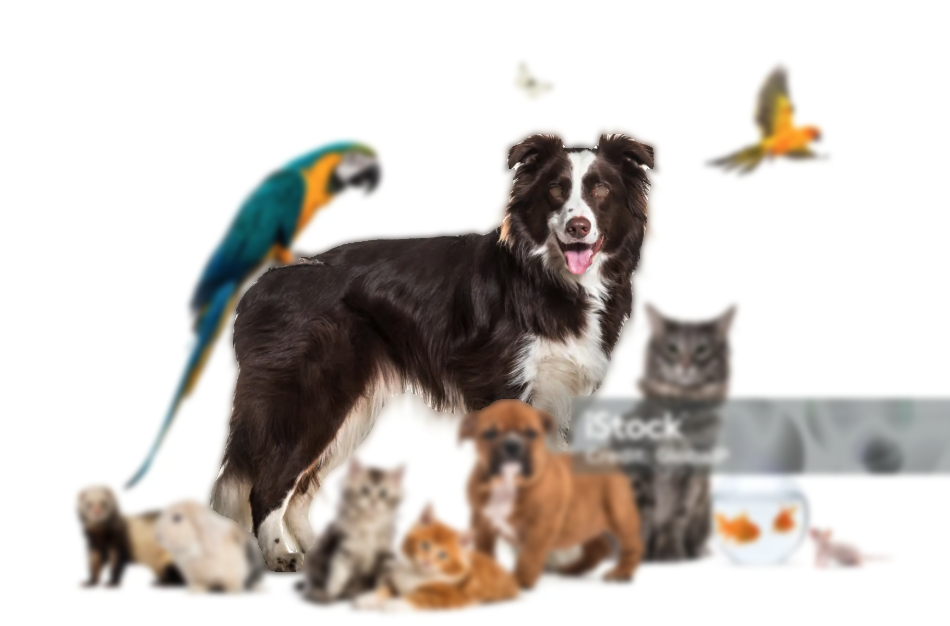

In [79]:
shallow_focus = create_shallow_focus(image, masks[0], blur_radius=3) # Adjust blur_radius

# shallow_focus.save("shallow_focus_image.png")  # Save the shallow focus image
# shallow_focus.show() # Display the shallow focus image (optional)

shallow_focus

merged masks

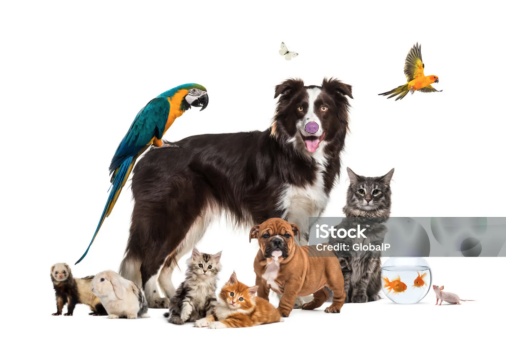

In [80]:
mask_on_img(image, masks[13])

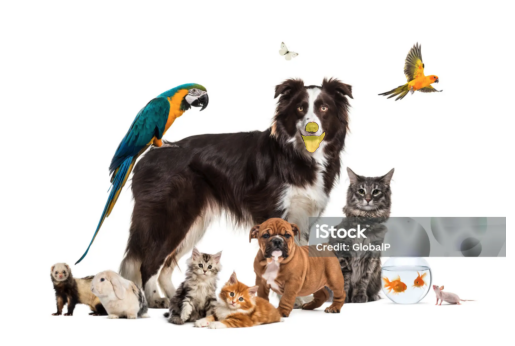

In [81]:
mask_on_img(image, masks[33])

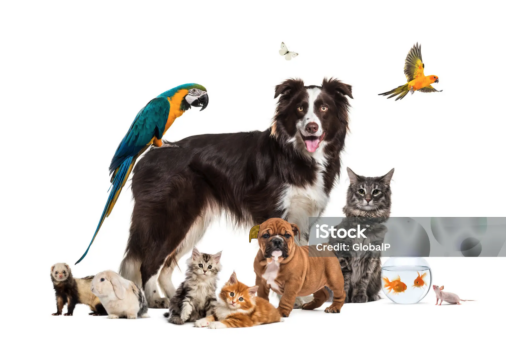

In [82]:
mask_on_img(image, masks[43])

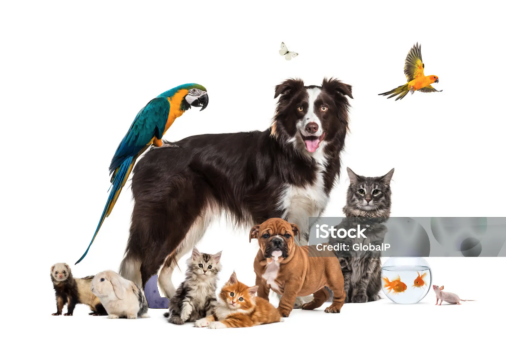

In [83]:
mask_on_img(image, masks[45])

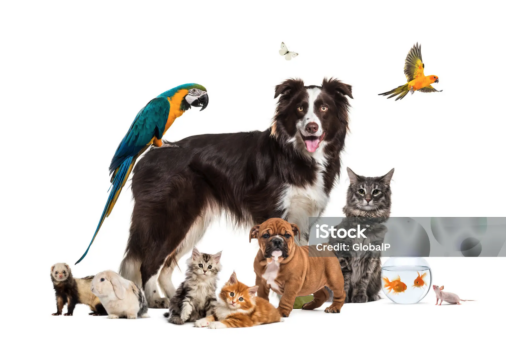

In [84]:
mask_on_img(image, masks[23])

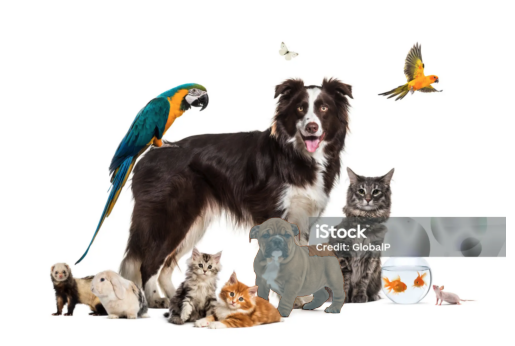

In [85]:
mask_on_img(image, masks[6])

In [86]:
def merge_masks_union(masks):
    """Merges multiple boolean masks using a union (OR) operation."""
    if not masks:  # Handle empty list of masks
        return np.zeros_like(masks[0], dtype=bool) if masks else np.array([])

    merged_mask = np.zeros_like(masks[0], dtype=bool) # Initialize with zeros

    for mask in masks:
        merged_mask = np.logical_or(merged_mask, mask) # Or use the | operator

    return merged_mask

In [89]:
merged_mask = merge_masks_union([masks[0],masks[13],masks[33],masks[43],masks[45],masks[6],masks[23]])

In [91]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os
import torch
from PIL import Image, ImageFilter
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation
from transformers import pipeline
import random
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Activation, Conv2D, Dropout, MaxPooling2D, SeparableConv2D, UpSampling2D, concatenate
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, ReLU, Add, Activation, BatchNormalization, Reshape
from google.colab.patches import cv2_imshow
import gc

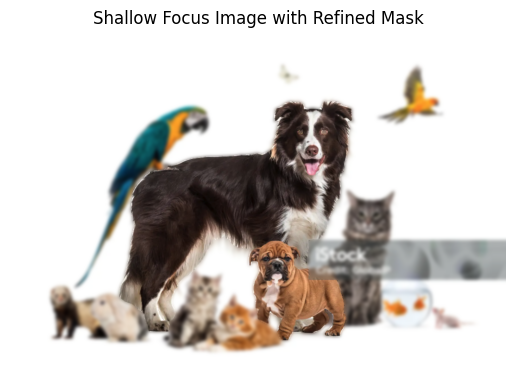

In [92]:
merged_mask = merge_masks_union([masks[0],masks[13],masks[33],masks[43],masks[45],masks[6],masks[23]])

# 1. 파라미터 설정 (사용자 조절 가능)
erosion_kernel_size = 3  # 침식 연산 커널 크기
dilation_kernel_size = 5 # 팽창 연산 커널 크기
blur_radius = 3 # 얕은 심도 효과 블러 반경

# 2. 개선된 마스크 생성
refined_merged_mask = refine_mask(merged_mask, erosion_kernel_size, dilation_kernel_size)

# 3. 얕은 심도 효과 적용
shallow_focus = create_shallow_focus(image, refined_merged_mask, blur_radius=blur_radius)

# 4. 최종 결과 출력 및 저장
plt.imshow(shallow_focus)
plt.axis("off")
plt.title("Shallow Focus Image with Refined Mask")
plt.show()

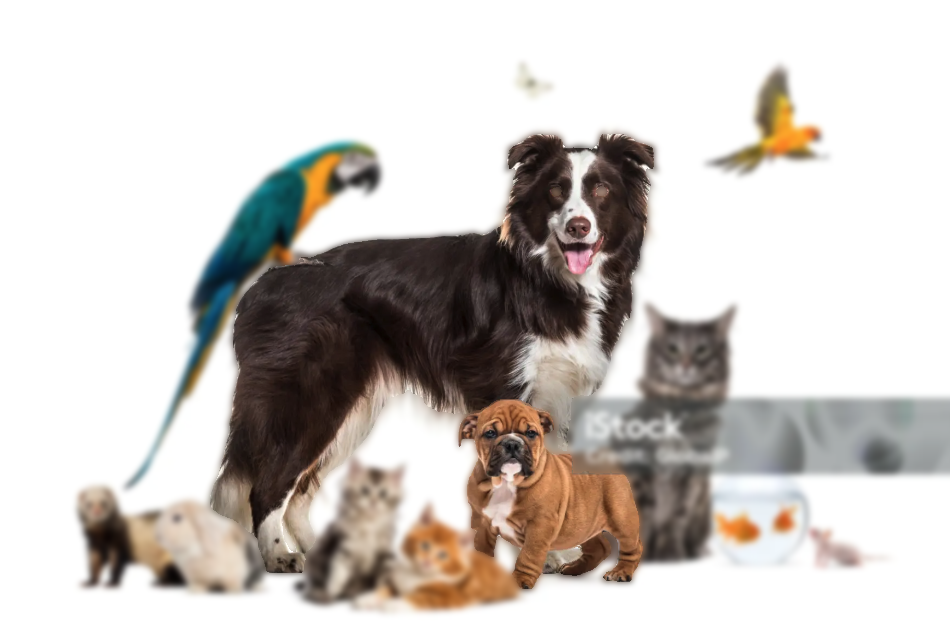

In [95]:
shallow_focus = create_shallow_focus(image, merged_mask, blur_radius=3) # Adjust blur_radius

# shallow_focus.save("shallow_focus_image.png")  # Save the shallow focus image
# shallow_focus.show() # Display the shallow focus image (optional)

shallow_focus

# 후처리 개선:

마스크 개선:

이미지 처리 기법: 침식(erosion), 팽창(dilation), 열기(opening), 닫기(closing)와 같은 이미지 처리 기법을 사용하여 마스크의 노이즈를 제거하고, 경계를 부드럽게 만들 수 있습니다.

Contour Detection: cv2.findContours() 함수를 사용하여 마스크에서 윤곽선을 추출하고, 윤곽선을 단순화하거나 다듬는 방법을 사용할 수 있습니다.

Conditional Random Field (CRF): CRF는 픽셀 간의 관계를 고려하여 세그멘테이션 결과를 개선하는 데 사용되는 확률 모델입니다. CRF를 적용하면 마스크의 일관성을 높이고, 경계를 더욱 정확하게 만들 수 있습니다.



블렌딩 개선:

가중치 조절: 전경과 배경 이미지를 블렌딩할 때, 각 이미지에 대한 가중치를 조절하여 더욱 자연스러운 결과를 얻을 수 있습니다.

Multi-Band Blending: Multi-Band Blending은 이미지의 주파수 성분을 분리하여 블렌딩하는 기법입니다. 이 기법을 사용하면 블렌딩 과정에서 발생하는 artifacts를 줄일 수 있습니다.

Poisson Blending: Poisson Blending은 이미지의 경계를 자연스럽게 합성하는 기법입니다. 이 기법을 사용하면 전경 이미지와 배경 이미지 간의 경계가 눈에 띄지 않도록 만들 수 있습니다.

# 1. 파라미터 설정 (사용자 조절 가능)
erosion_kernel_size = 10  # 침식 연산 커널 크기 /
dilation_kernel_size = 15 # 팽창 연산 커널 크기

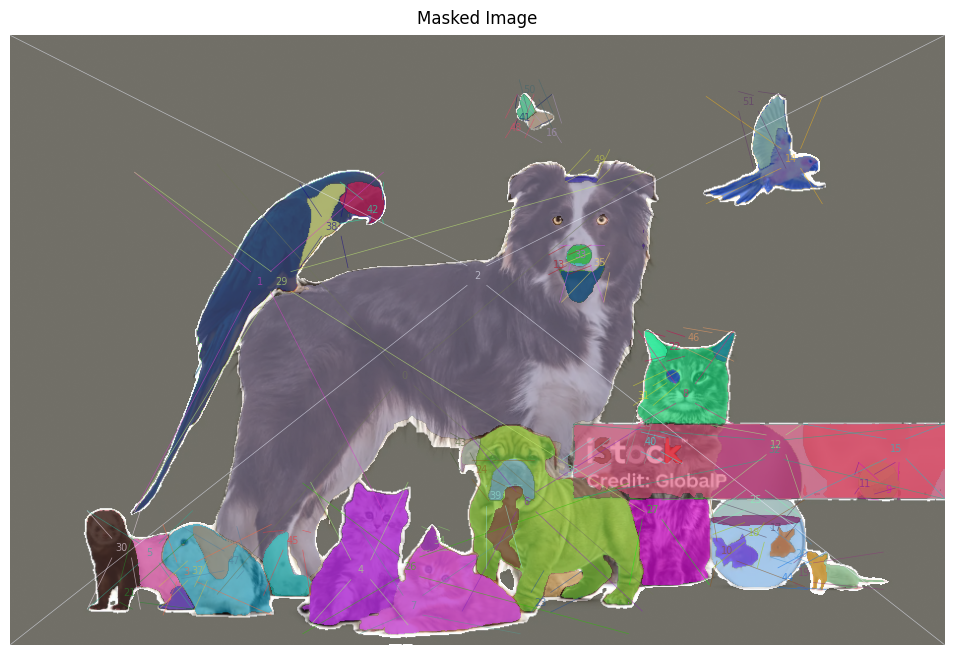

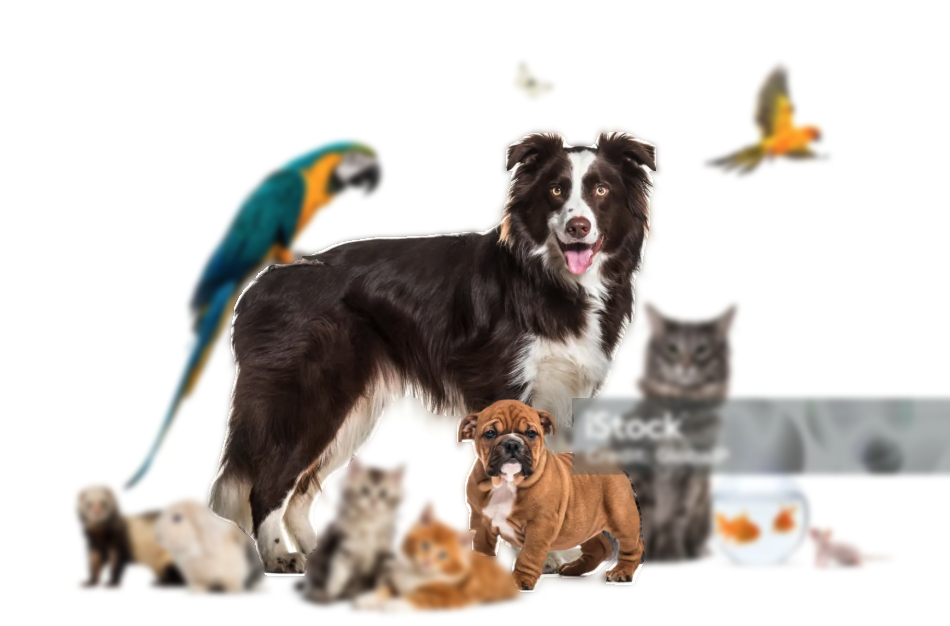

In [96]:
image = Image.open("/content/drive/MyDrive/data/15.png").convert("RGB")
outputs = generator(image, points_per_batch=64)

masks = outputs["masks"]
ax_returned = show_masks_on_image(image, masks, filename="my_masked_image.png")
ax_returned.set_title("Masked Image")
plt.figure(ax_returned.figure) # Important: Get the figure that contains the axes
plt.show() # Now show the plot

def mask_on_img(image, mask):
  plt.imshow(image)
  ax = plt.gca()
  ax.set_autoscale_on(False)
  show_mask(mask, ax=ax, random_color=True)
  plt.axis("off")
  plt.show()

from PIL import Image, ImageFilter

def create_shallow_focus(image, mask, blur_radius=5):
    """Creates a shallow focus image using the masks."""

    image_pil = Image.fromarray(np.array(image))  # Convert to PIL Image

    # Create blurred image
    blurred_image = image_pil.filter(ImageFilter.GaussianBlur(radius=blur_radius))

    # Composite the images using the masks
    shallow_focus_image = image_pil.copy() # Copy the image to avoid modifying the original

    mask_pil = Image.fromarray((mask * 255).astype(np.uint8))
    shallow_focus_image = Image.composite(shallow_focus_image, blurred_image, mask_pil) # Composite using the mask

    return shallow_focus_image

shallow_focus = create_shallow_focus(image, masks[0], blur_radius=3) # Adjust blur_radius

# shallow_focus.save("shallow_focus_image.png")  # Save the shallow focus image
# shallow_focus.show() # Display the shallow focus image (optional)

shallow_focus

def merge_masks_union(masks):
    """Merges multiple boolean masks using a union (OR) operation."""
    if not masks:  # Handle empty list of masks
        return np.zeros_like(masks[0], dtype=bool) if masks else np.array([])

    merged_mask = np.zeros_like(masks[0], dtype=bool) # Initialize with zeros

    for mask in masks:
        merged_mask = np.logical_or(merged_mask, mask) # Or use the | operator

    return merged_mask

merged_mask = merge_masks_union([masks[0],masks[13],masks[33],masks[43],masks[45],masks[6],masks[23]])

# 1. 파라미터 설정 (사용자 조절 가능)
erosion_kernel_size = 10  # 침식 연산 커널 크기
dilation_kernel_size = 15 # 팽창 연산 커널 크기

# 2. 개선된 마스크 생성
refined_merged_mask = refine_mask(merged_mask, erosion_kernel_size, dilation_kernel_size)

# 3. 얕은 심도 효과 적용
shallow_focus = create_shallow_focus(image, refined_merged_mask, blur_radius=3) # Adjust blur_radius

# shallow_focus.save("shallow_focus_image.png")  # Save the shallow focus image
# shallow_focus.show() # Display the shallow focus image (optional)

shallow_focus

# 1. 파라미터 설정 (사용자 조절 가능)
erosion_kernel_size = 1  # 침식 연산 커널 크기 /
dilation_kernel_size = 1 # 팽창 연산 커널 크기

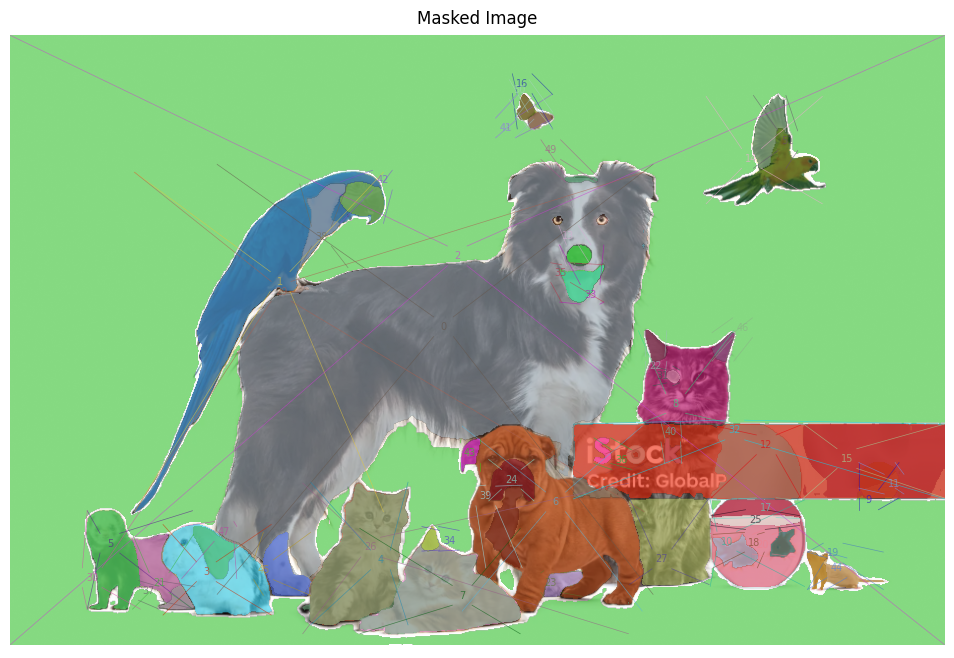

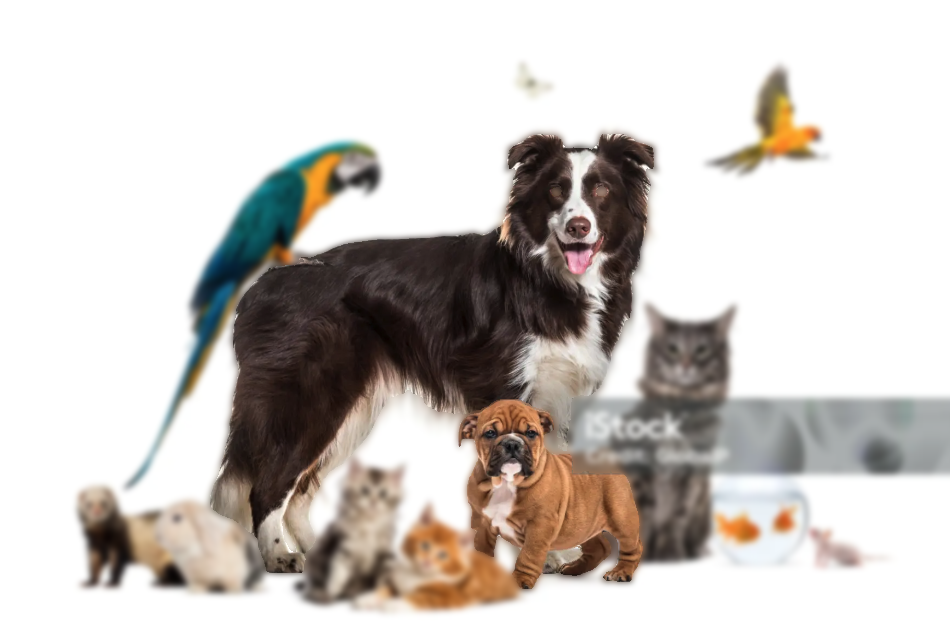

In [94]:
image = Image.open("/content/drive/MyDrive/data/15.png").convert("RGB")
outputs = generator(image, points_per_batch=64)

masks = outputs["masks"]
ax_returned = show_masks_on_image(image, masks, filename="my_masked_image.png")
ax_returned.set_title("Masked Image")
plt.figure(ax_returned.figure) # Important: Get the figure that contains the axes
plt.show() # Now show the plot

def mask_on_img(image, mask):
  plt.imshow(image)
  ax = plt.gca()
  ax.set_autoscale_on(False)
  show_mask(mask, ax=ax, random_color=True)
  plt.axis("off")
  plt.show()

from PIL import Image, ImageFilter

def create_shallow_focus(image, mask, blur_radius=5):
    """Creates a shallow focus image using the masks."""

    image_pil = Image.fromarray(np.array(image))  # Convert to PIL Image

    # Create blurred image
    blurred_image = image_pil.filter(ImageFilter.GaussianBlur(radius=blur_radius))

    # Composite the images using the masks
    shallow_focus_image = image_pil.copy() # Copy the image to avoid modifying the original

    mask_pil = Image.fromarray((mask * 255).astype(np.uint8))
    shallow_focus_image = Image.composite(shallow_focus_image, blurred_image, mask_pil) # Composite using the mask

    return shallow_focus_image

shallow_focus = create_shallow_focus(image, masks[0], blur_radius=3) # Adjust blur_radius

# shallow_focus.save("shallow_focus_image.png")  # Save the shallow focus image
# shallow_focus.show() # Display the shallow focus image (optional)

shallow_focus

def merge_masks_union(masks):
    """Merges multiple boolean masks using a union (OR) operation."""
    if not masks:  # Handle empty list of masks
        return np.zeros_like(masks[0], dtype=bool) if masks else np.array([])

    merged_mask = np.zeros_like(masks[0], dtype=bool) # Initialize with zeros

    for mask in masks:
        merged_mask = np.logical_or(merged_mask, mask) # Or use the | operator

    return merged_mask

merged_mask = merge_masks_union([masks[0],masks[13],masks[33],masks[43],masks[45],masks[6],masks[23]])

# 1. 파라미터 설정 (사용자 조절 가능)
erosion_kernel_size = 1  # 침식 연산 커널 크기
dilation_kernel_size = 1 # 팽창 연산 커널 크기

# 2. 개선된 마스크 생성
refined_merged_mask = refine_mask(merged_mask, erosion_kernel_size, dilation_kernel_size)

# 3. 얕은 심도 효과 적용
shallow_focus = create_shallow_focus(image, refined_merged_mask, blur_radius=3) # Adjust blur_radius

# shallow_focus.save("shallow_focus_image.png")  # Save the shallow focus image
# shallow_focus.show() # Display the shallow focus image (optional)

shallow_focus

# 파라미터	               값이 커질수록	                   값이 작아질수록

erosion_kernel_size(침식 연산 커널 크기)	  객체 축소, 노이즈 제거 강력하게	 /   객체 축소 감소, 노이즈 제거 약하게


dilation_kernel_size(팽창 연산 커널 크기)	객체 확장, 끊어진 선 연결 강력하게	 / 객체 확장 감소, 끊어진 선 연결약하게


1. erosion_kernel_size (침식 연산 커널 크기):

값이 작아질수록:

침식 강도 감소: 더 적은 픽셀이 침식 연산에 의해 제거됩니다.

객체 축소 감소: 이미지에서 객체의 크기가 덜 줄어듭니다.

세밀한 디테일 보존: 작은 객체나 세밀한 디테일이 더 많이 보존됩니다.

노이즈 제거 효과 감소: 작은 노이즈 픽셀이나 돌출된 부분이 덜 제거됩니다.

마스크 축소 감소: 마스크 영역이 덜 축소되어, 세그멘테이션 결과에서 객체 영역이 덜 줄어듭니다.

요약: erosion_kernel_size가 작아질수록 약하게 객체를 깎아내고, 노이즈를 제거합니다.


2. dilation_kernel_size (팽창 연산 커널 크기):

값이 작아질수록:

팽창 강도 감소: 더 적은 픽셀이 팽창 연산에 의해 추가됩니다.

객체 확장 감소: 이미지에서 객체의 크기가 덜 늘어납니다.

끊어진 선 연결 감소: 끊어진 선이나 경계가 덜 연결됩니다.

빈 공간 채우기 감소: 객체 내부의 작은 빈 공간이 덜 채워집니다.

마스크 확장 감소: 마스크 영역이 덜 확장되어, 세그멘테이션 결과에서 객체 영역이 덜 늘어납니다.

요약: dilation_kernel_size가 작아질수록 약하게 객체를 확장하고, 끊어진 부분을 연결합니다.



(예시)

이미지: 검은색 배경에 흰색 점들이 흩뿌려져 있고, 가운데에 흰색 원이 있는 이미지

커널: 3x3 크기의 모든 요소가 1인 정사각형 커널

침식 -> 팽창: 흰색 점들이 대부분 제거되고, 흰색 원의 크기가 약간 줄어들었다가 다시 원래 크기에 가깝게 복원됩니다.

팽창 -> 침식: 흰색 점들이 흰색 원과 합쳐지고, 흰색 원의 경계가 불분명해집니다.